In [4]:
import pandas as pd
import numpy as np
from PlotUtil import apply_report_formatting

telesat_passes_df = pd.read_pickle('Telesat_0_7day.pkl')

N_passes = 20
telesat_passes_df = telesat_passes_df[0:N_passes]

def transform_sff(passes_df): 
    import quaternion as qn
    
    qq = [None] * len(passes_df)
    ll = [None] * len(passes_df)
    
    # Todo make this properly vectorized
    for i, pass_df in passes_df.iterrows():
        rr_a = pass_df.rr_a
        rr_ab = pass_df.rr_b - pass_df.rr_a
            
        # Start by finding the rotation of the sc in the ECIF
        z_ecif = np.array([[0,0,1]])
        
        def rotate_vectors(qq, vv):
            vvp = np.zeros(vv.shape)
            for j, q in enumerate(qq):
                q = q.normalized()
                vvp[j, :] = (q * np.quaternion(0, vv[j, 0], vv[j, 1], vv[j, 2]) * q.inverse()).vec
    
            return vvp

        ## New method
        vv1 = rr_a
        vv2 = z_ecif
        
        def find_quat(v1, v2):
            # v1 - vector to rotate to
            # v2 - vector to rotate from
            xyz = np.cross(v1, v2)
            x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
            w = np.sqrt(np.linalg.norm(v1, axis=1) ** 2 * np.linalg.norm(v2, axis=1)**2) + np.sum(v1*v2, axis=1)
            n = np.sqrt(x**2 + y**2 +  z**2 + w**2)
            return qn.as_quat_array(np.array([w, x, y, z]).T) / n
        
        qq[i] = find_quat(vv1, vv2)
        ll[i] = rotate_vectors(qq[i], rr_ab)

    passes_df['qq'] = qq
    passes_df['ll'] = ll
    return passes_df

telesat_passes_df = transform_sff(telesat_passes_df)
  
def non_overlapping_constraint(passes_df):
    # Construct the non-overlapping pass matrix
    b = passes_df.StartTof.values
    e = passes_df.StopTof.values

    B = np.tile(b, (len(passes_df), 1)).T
    E = np.tile(e, (len(passes_df), 1))

    C = np.tril(E - B, -1)

    return C

C = non_overlapping_constraint(telesat_passes_df)

In [5]:
import numpy as np

from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=N_passes, n_obj=1, n_constr=N_passes*N_passes, xl=0, xu=1, type_var=np.int)

    def _evaluate(self, xx, out, *args, **kwargs):

        f1 = np.zeros((np.size(xx, 0), 1))
        g1 = np.zeros((np.size(xx, 0), N_passes*N_passes))

        # not vectorized
        for i in range(np.size(xx, 0)):
            x = xx[i,:]

            b = telesat_passes_df.StartTof[x == 1].values
            e = telesat_passes_df.StopTof[x == 1].values

            contact_time = np.sum(e - b)

            overlap = C * x

            f1[i] = -1 * contact_time
            g1[i,:] = overlap.flatten()

        out["F"] = f1
        out["G"] = g1

method = get_algorithm("ga",
                       pop_size=20,
                       sampling=get_sampling("int_random"),
                       crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
                       mutation=get_mutation("int_pm", eta=3.0),
                       eliminate_duplicates=True,
                       )

res = minimize(MyProblem(),
               method,
               termination=('n_gen', 40),
               seed=1,
               save_history=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %.2f" % res.F)
print("Constraint violation: %s" % res.CV)

Best solution found: [1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1]
Function value: -1990.00
Constraint violation: [0.]


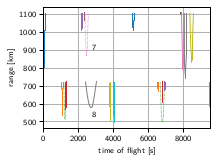

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3.2, 2.4))

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'sans-serif',
    'text.usetex': False,
    'pgf.rcfonts': False
})

lines = [None] * N_passes
for n in range(N_passes):
    pass_df = telesat_passes_df.iloc[n]
    line, = plt.plot(pass_df.ttof, pass_df.rrange / 1000., linewidth=0.5)
    lines[n] = line

plt.xlabel('time of flight [s]')
plt.ylabel('range [km]')
plt.grid()
plt.xlim((0, telesat_passes_df.iloc[-1].StopTof))
plt.tight_layout()

for i in np.where(res.X != 1)[0]:
    lines[i].set_linestyle('dotted')

plt.annotate('7', (2800,900), fontsize=8)
plt.annotate('8', (2800,530), fontsize=8)
apply_report_formatting()
plt.savefig('D:/git/thesis_report_ae/figures/passes_marked.pgf')

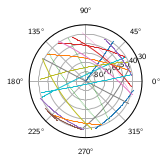

In [7]:
fig = plt.figure(figsize=(2.4, 2.4))

lines = [None] * N_passes

def xyz_to_shperical(xyz):
    xy = xyz[:,0]**2 + xyz[:,1]**2
    r = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    phi = np.arctan2(xyz[:,1], xyz[:,0])
    return r, theta, phi

for i, pass_df in telesat_passes_df.head(N_passes).iterrows():
    ll = pass_df.ll/1000
    r, theta, phi = xyz_to_shperical(ll)
    line, = plt.polar(phi, theta * 180 / np.pi, linewidth=0.5)
    lines[i] = line
    
for i in np.where(res.X != 1)[0]:
    lines[i].set_linestyle('dotted')
    
plt.yticks(ticks=plt.yticks()[0], labels=["%d" % v for v in 90 - np.array(plt.yticks()[0])])
#plt.grid()
plt.tight_layout()
# plt.subplots_adjust(bottom=0.1)
apply_report_formatting()
plt.savefig('D:/git/thesis_report_ae/figures/skyplot_marked.pgf')

